In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2

# Path to the face dataset and the pre-trained model
face_dataset_dir = "siamese_face_dataset"  # Replace with your dataset path
face_model_path = "fine_tuned_arcface_model_with_haar.h5"  # Path to the pre-trained ArcFace model

# Parameters
img_size_face = 112  # Input size for the ArcFace model
test_ratio = 0.2     # 20% data for testing

# Load Haar Cascade for face detection
haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# Function to detect and crop faces
def detect_and_crop_face(image_path, target_size=(112, 112)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading {image_path}. Skipping.")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print(f"No face detected in {image_path}. Skipping.")
        return None

    # Crop the first detected face
    x, y, w, h = faces[0]
    cropped_face = img[y:y+h, x:x+w]
    cropped_face = cv2.resize(cropped_face, target_size)
    cropped_face = cropped_face / 255.0  # Normalize
    return cropped_face

# Load and preprocess the dataset
def load_face_dataset(directory, img_size):
    images = []
    labels = []
    users = os.listdir(directory)
    for user in users:
        user_path = os.path.join(directory, user)
        if os.path.isdir(user_path):
            for img_name in os.listdir(user_path):
                img_path = os.path.join(user_path, img_name)
                face = detect_and_crop_face(img_path, target_size=(img_size, img_size))
                if face is not None:
                    images.append(face)
                    labels.append(user)
    return np.array(images), np.array(labels)

print("Loading face dataset...")
face_images, face_labels = load_face_dataset(face_dataset_dir, img_size_face)

# Split dataset into training and testing sets
print("Splitting dataset...")
train_images, test_images, train_labels, test_labels = train_test_split(
    face_images, face_labels, test_size=test_ratio, stratify=face_labels, random_state=42
)

# Load the pre-trained ArcFace model
print("Loading ArcFace model...")
full_model = load_model(face_model_path, compile=False)

# Extract the base embedding model
print("Extracting base model for embeddings...")
base_model = Model(inputs=full_model.input, outputs=full_model.layers[-2].output)  # Use the second last layer

# Generate embeddings for the test set
print("Generating face test embeddings...")
test_images = test_images.reshape(-1, img_size_face, img_size_face, 3)  # Ensure shape is compatible
face_test_embeddings = base_model.predict(test_images, batch_size=32, verbose=1)

# Save the embeddings and labels
np.save("face_test_embeddings.npy", face_test_embeddings)
np.save("face_test_labels.npy", test_labels)

print("Face test embeddings generated and saved successfully!")


Loading face dataset...
No face detected in siamese_face_dataset\User_29\Tiger_Woods_0010.jpg. Skipping.
No face detected in siamese_face_dataset\User_48\Yasser_Arafat_0004.jpg. Skipping.
No face detected in siamese_face_dataset\User_48\Yasser_Arafat_0007.jpg. Skipping.
Splitting dataset...
Loading ArcFace model...
Extracting base model for embeddings...
Generating face test embeddings...
3/3 [==============================] - 2s 284ms/step
Face test embeddings generated and saved successfully!


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

# Load the pre-trained fingerprint model
print("Loading fingerprint model...")
full_model = load_model("siamese_model.h5", compile=False)  # Replace with your model path

# Extract the base embedding model (shared base network)
fingerprint_base_model = full_model.get_layer(index=2)

# Verify the base model structure
fingerprint_base_model.summary()

# Function to load and preprocess fingerprint images
def load_fingerprint_images(directory, img_size):
    images, labels = [], []
    for user_folder in os.listdir(directory):
        user_path = os.path.join(directory, user_folder)
        if os.path.isdir(user_path):
            for img_name in os.listdir(user_path):
                img_path = os.path.join(user_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))
                    img = img / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img)
                    labels.append(user_folder)
    return np.array(images), np.array(labels)

# Path to the fingerprint dataset
fingerprint_dataset_dir = "CrossMatch_Sample_DB"  # Replace with your dataset path

# Load and preprocess fingerprint test images
print("Loading fingerprint test images...")
fingerprint_images, fingerprint_labels = load_fingerprint_images(fingerprint_dataset_dir, img_size=128)

# Reshape images to match the input shape of the model
fingerprint_images = fingerprint_images.reshape(-1, 128, 128, 1)

# Generate test embeddings using the base model
print("Generating fingerprint test embeddings...")
fingerprint_test_embeddings = fingerprint_base_model.predict(fingerprint_images, batch_size=32, verbose=1)

# Save embeddings and labels
np.save("fingerprint_test_embeddings.npy", fingerprint_test_embeddings)
np.save("fingerprint_test_labels.npy", fingerprint_labels)

print("Fingerprint test embeddings generated and saved successfully!")


Loading fingerprint model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (No

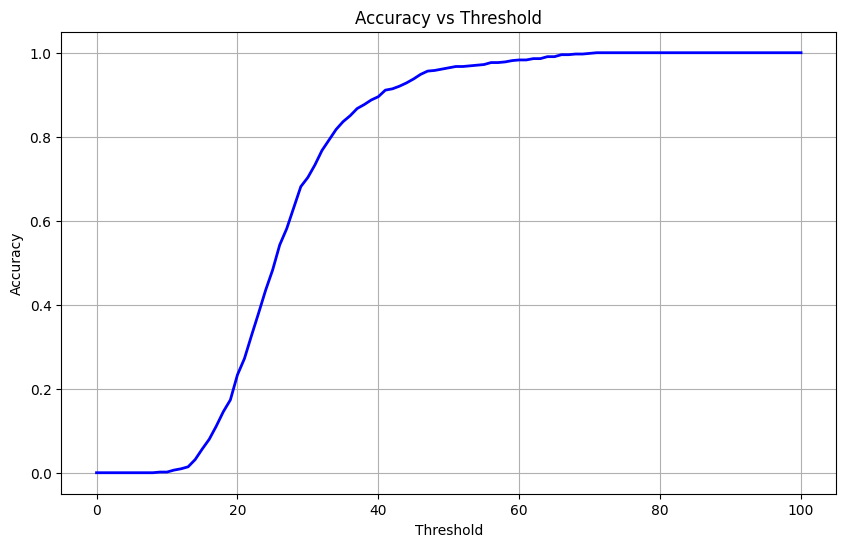

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the combined test embeddings and labels
fingerprint_test_embeddings = np.load('fingerprint_test_embeddings.npy')
fingerprint_test_labels = np.load('fingerprint_test_labels.npy')
face_test_embeddings = np.load('face_test_embeddings.npy')
face_test_labels = np.load('face_test_labels.npy')

# Combine embeddings for the same users
combined_test_embeddings = []
combined_test_labels = []

for user_id in np.unique(fingerprint_test_labels):
    # Get the indices of the user in both datasets (fingerprint and face)
    user_fingerprint_indices = np.where(fingerprint_test_labels == user_id)[0]
    user_face_indices = np.where(face_test_labels == user_id)[0]

    # Ensure that user exists in both datasets
    if len(user_fingerprint_indices) > 0 and len(user_face_indices) > 0:
        for fingerprint_idx in user_fingerprint_indices:
            for face_idx in user_face_indices:
                # Combine the fingerprint and face embeddings for the same user
                combined_embedding = np.concatenate([fingerprint_test_embeddings[fingerprint_idx], face_test_embeddings[face_idx]], axis=0)
                combined_test_embeddings.append(combined_embedding)
                combined_test_labels.append(user_id)

# Convert combined test embeddings and labels to numpy arrays
combined_test_embeddings = np.array(combined_test_embeddings)
combined_test_labels = np.array(combined_test_labels)

# Load the combined trained embeddings (in dictionary format)
trained_combined_embeddings = np.load('combined_embeddings.npy', allow_pickle=True).item()

# Now, for each combined test embedding, find the corresponding final trained embedding of the same user
distances = []
actual=[]
for idx, combined_test_embedding in enumerate(combined_test_embeddings):
    user_id = combined_test_labels[idx]
    
    # Fetch the final trained embedding for the same user from the dictionary
    trained_user_embedding = trained_combined_embeddings.get(user_id)
    
    if trained_user_embedding is not None:
        # Compute the Euclidean distance between the combined test embedding and the trained embedding
        distance = np.linalg.norm(combined_test_embedding - trained_user_embedding)
        distances.append(distance)
        actual.append(1)
    else:
        print(f"Warning: No trained embedding found for {user_id}")
        continue

distances = np.array(distances)

# Store accuracy for each threshold
thresholds = []
accuracies = []
# Vary the threshold from 0 to 100 and calculate accuracy for each threshold
for threshold in range(101):
    predictions = []
    
    for distance in distances:
        if distance < threshold:
            predictions.append(1)  # Match (same user)
        else:
            predictions.append(0)  # Non-match (different user)
    
    # Calculate accuracy for the current threshold
    accuracy = accuracy_score(actual, predictions)
    thresholds.append(threshold)
    accuracies.append(accuracy)


# Plot the graph between accuracy and threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, color='blue', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)
plt.show()


Unique actual_labels: [0 1]
Length of distances: 32000
Length of actual_labels: 32000
Unique actual_labels: [0 1]
Are there NaN values in distances? False
far :  0.026658163265306123
frr :  0.03281250000000002
EER: 0.0297
Threshold at EER: -50.6121


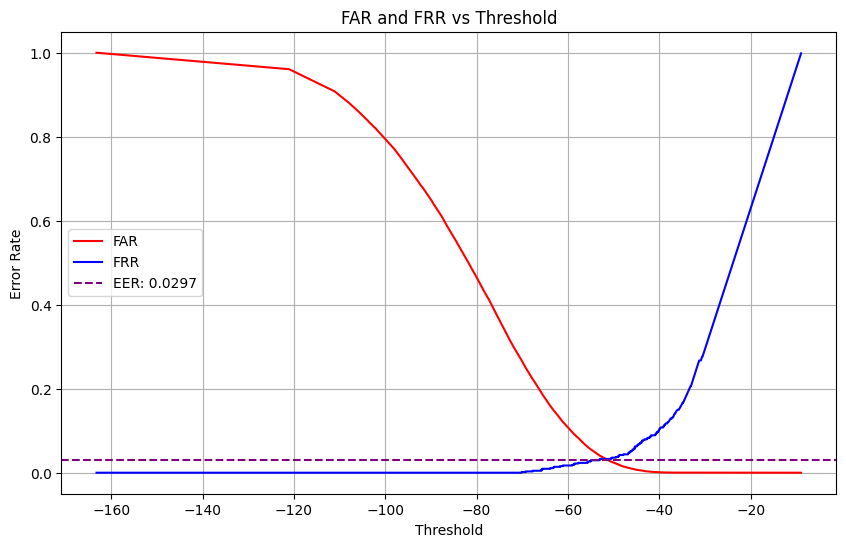

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Load the combined test embeddings and labels
fingerprint_test_embeddings = np.load('fingerprint_test_embeddings.npy')
fingerprint_test_labels = np.load('fingerprint_test_labels.npy')
face_test_embeddings = np.load('face_test_embeddings.npy')
face_test_labels = np.load('face_test_labels.npy')

# Combine embeddings for the same users
combined_test_embeddings = []
combined_test_labels = []

for user_id in np.unique(fingerprint_test_labels):
    # Get the indices of the user in both datasets (fingerprint and face)
    user_fingerprint_indices = np.where(fingerprint_test_labels == user_id)[0]
    user_face_indices = np.where(face_test_labels == user_id)[0]

    # Ensure that user exists in both datasets
    if len(user_fingerprint_indices) > 0 and len(user_face_indices) > 0:
        for fingerprint_idx in user_fingerprint_indices:
            for face_idx in user_face_indices:
                # Combine the fingerprint and face embeddings for the same user
                combined_embedding = np.concatenate([fingerprint_test_embeddings[fingerprint_idx], face_test_embeddings[face_idx]], axis=0)
                combined_test_embeddings.append(combined_embedding)
                combined_test_labels.append(user_id)

# Convert combined test embeddings and labels to numpy arrays
combined_test_embeddings = np.array(combined_test_embeddings)
combined_test_labels = np.array(combined_test_labels)

# Load the combined trained embeddings (in dictionary format)
trained_combined_embeddings = np.load('combined_embeddings.npy', allow_pickle=True).item()

# Calculate distances and generate ground truth (actual matches)
distances = []
actual_labels = []

for idx, combined_test_embedding in enumerate(combined_test_embeddings):
    user_id = combined_test_labels[idx]
    
    # Fetch the trained embedding for the genuine user
    trained_user_embedding = trained_combined_embeddings.get(user_id)
    
    # Genuine match
    if trained_user_embedding is not None:
        distance = np.linalg.norm(combined_test_embedding - trained_user_embedding)
        distances.append(distance)
        actual_labels.append(1)  # Genuine match
    
    # Impostor cases: Compare with embeddings of other users
    for other_user_id, other_user_embedding in trained_combined_embeddings.items():
        if other_user_id != user_id:  # Exclude the same user
            impostor_distance = np.linalg.norm(combined_test_embedding - other_user_embedding)
            distances.append(impostor_distance)
            actual_labels.append(0)  # Impostor match

print("Unique actual_labels:", np.unique(actual_labels))


distances = np.array(distances)
actual_labels = np.array(actual_labels)

print("Length of distances:", len(distances))
print("Length of actual_labels:", len(actual_labels))
print("Unique actual_labels:", np.unique(actual_labels))
print("Are there NaN values in distances?", np.isnan(distances).any())

# Calculate FAR, FRR, and thresholds
fpr, tpr, thresholds = roc_curve(actual_labels, -distances)  # Negate distances for compatibility

# False Acceptance Rate (FAR) = FPR, False Rejection Rate (FRR) = 1 - TPR
far = fpr
frr = 1 - tpr


# Find the EER (where FAR and FRR are approximately equal)
eer_threshold_index = np.nanargmin(np.abs(far - frr))
eer_threshold = thresholds[eer_threshold_index]
eer = (far[eer_threshold_index] + frr[eer_threshold_index]) / 2

print("far : ",far[eer_threshold_index])
print("frr : ",frr[eer_threshold_index])

# Print EER and the corresponding threshold
print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

# Plot FAR, FRR, and EER
plt.figure(figsize=(10, 6))
plt.plot(thresholds, far, label='FAR', color='red')
plt.plot(thresholds, frr, label='FRR', color='blue')
# plt.axvline(x=eer_threshold, color='green', linestyle='--', label=f'EER Threshold: {eer_threshold:.4f}')
plt.axhline(y=eer, color='purple', linestyle='--', label=f'EER: {eer:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FAR and FRR vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


Unique actual_labels: [0 1]
far : 0.026658163265306123
frr : 0.03281250000000002
EER: 0.0297
Threshold at EER: -50.6121


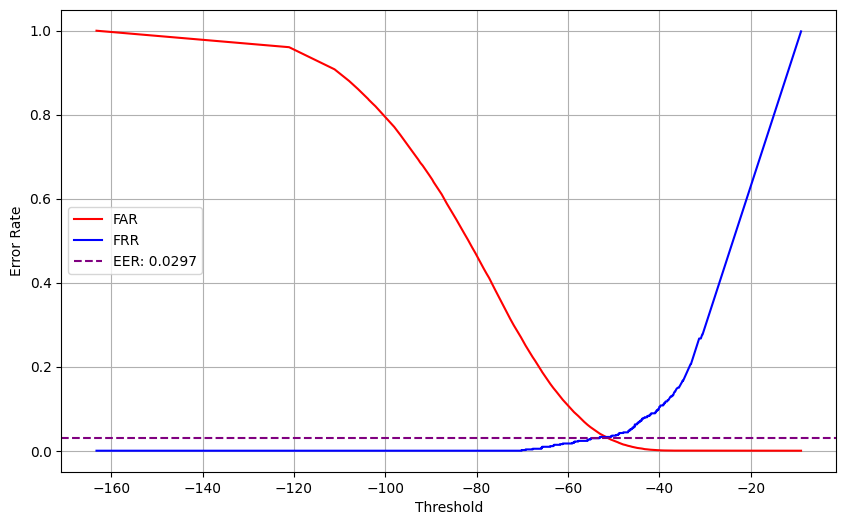

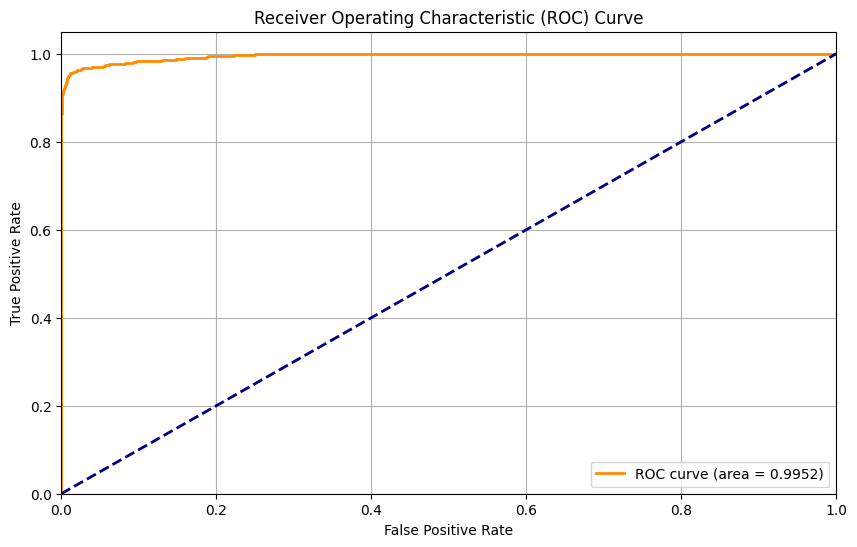

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the combined test embeddings and labels
fingerprint_test_embeddings = np.load('fingerprint_test_embeddings.npy')
fingerprint_test_labels = np.load('fingerprint_test_labels.npy')
face_test_embeddings = np.load('face_test_embeddings.npy')
face_test_labels = np.load('face_test_labels.npy')

# Combine embeddings for the same users
combined_test_embeddings = []
combined_test_labels = []

for user_id in np.unique(fingerprint_test_labels):
    user_fingerprint_indices = np.where(fingerprint_test_labels == user_id)[0]
    user_face_indices = np.where(face_test_labels == user_id)[0]

    if len(user_fingerprint_indices) > 0 and len(user_face_indices) > 0:
        for fingerprint_idx in user_fingerprint_indices:
            for face_idx in user_face_indices:
                combined_embedding = np.concatenate([fingerprint_test_embeddings[fingerprint_idx], face_test_embeddings[face_idx]], axis=0)
                combined_test_embeddings.append(combined_embedding)
                combined_test_labels.append(user_id)

combined_test_embeddings = np.array(combined_test_embeddings)
combined_test_labels = np.array(combined_test_labels)

# Load trained embeddings
trained_combined_embeddings = np.load('combined_embeddings.npy', allow_pickle=True).item()

distances = []
actual_labels = []

for idx, combined_test_embedding in enumerate(combined_test_embeddings):
    user_id = combined_test_labels[idx]
    trained_user_embedding = trained_combined_embeddings.get(user_id)
    
    if trained_user_embedding is not None:
        distance = np.linalg.norm(combined_test_embedding - trained_user_embedding)
        distances.append(distance)
        actual_labels.append(1)
    
    for other_user_id, other_user_embedding in trained_combined_embeddings.items():
        if other_user_id != user_id:
            impostor_distance = np.linalg.norm(combined_test_embedding - other_user_embedding)
            distances.append(impostor_distance)
            actual_labels.append(0)

print("Unique actual_labels:", np.unique(actual_labels))

distances = np.array(distances)
actual_labels = np.array(actual_labels)

# Compute FAR, FRR, and ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, -distances)  # Negate distances for compatibility
far = fpr
frr = 1 - tpr

eer_threshold_index = np.nanargmin(np.abs(far - frr))
eer_threshold = thresholds[eer_threshold_index]
eer = (far[eer_threshold_index] + frr[eer_threshold_index]) / 2

eer_fpr = far[eer_threshold_index]
eer_frr = frr[eer_threshold_index]
print("far :", eer_fpr)
print("frr :", eer_frr)
print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

# Plot FAR, FRR, and EER
plt.figure(figsize=(10, 6))
plt.plot(thresholds, far, label='FAR', color='red')
plt.plot(thresholds, frr, label='FRR', color='blue')
plt.axhline(y=eer, color='purple', linestyle='--', label=f'EER: {eer:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FAR and FRR vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Compute ROC curve and AUC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Unique actual_labels: [0 1]
far : 0.038979591836734696
frr : 0.040000000000000036
EER: 0.0395
Threshold at EER: -47.2873


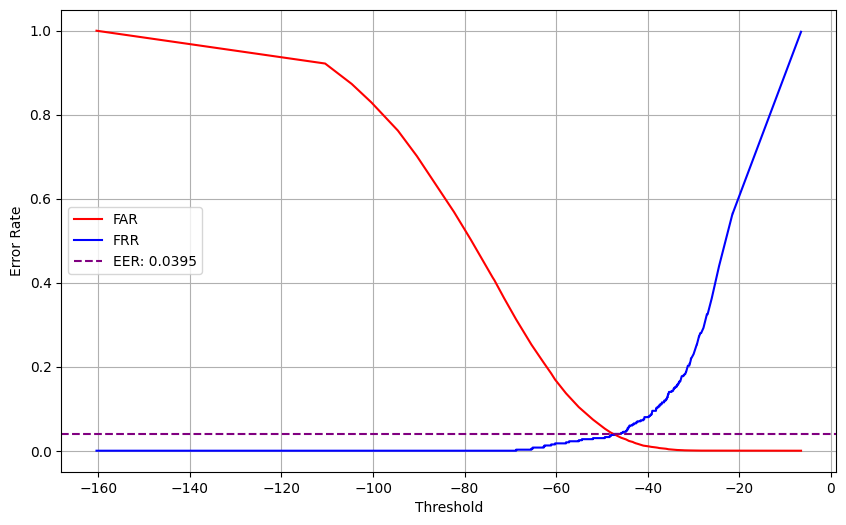

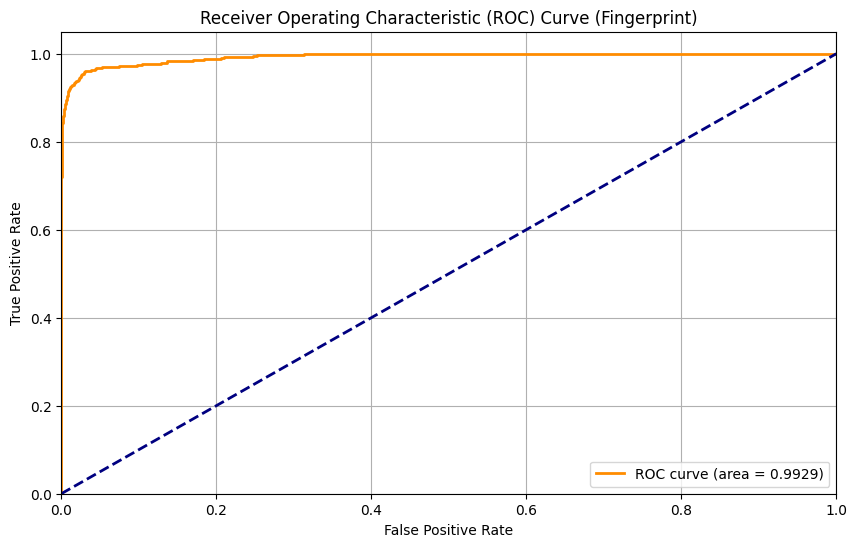

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the fingerprint test embeddings and labels
fingerprint_test_embeddings = np.load('fingerprint_test_embeddings.npy')
fingerprint_test_labels = np.load('fingerprint_test_labels.npy')

# Load trained fingerprint embeddings
trained_fingerprint_embeddings = np.load('fingerprint_embeddings.npy', allow_pickle=True).item()

distances = []
actual_labels = []

for idx, fingerprint_test_embedding in enumerate(fingerprint_test_embeddings):
    user_id = fingerprint_test_labels[idx]
    trained_user_embedding = trained_fingerprint_embeddings.get(user_id)
    
    if trained_user_embedding is not None:
        distance = np.linalg.norm(fingerprint_test_embedding - trained_user_embedding)
        distances.append(distance)
        actual_labels.append(1)
    
    for other_user_id, other_user_embedding in trained_fingerprint_embeddings.items():
        if other_user_id != user_id:
            impostor_distance = np.linalg.norm(fingerprint_test_embedding - other_user_embedding)
            distances.append(impostor_distance)
            actual_labels.append(0)

print("Unique actual_labels:", np.unique(actual_labels))

distances = np.array(distances)
actual_labels = np.array(actual_labels)

# Compute FAR, FRR, and ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, -distances)  # Negate distances for compatibility
far = fpr
frr = 1 - tpr

eer_threshold_index = np.nanargmin(np.abs(far - frr))
eer_threshold = thresholds[eer_threshold_index]
eer = (far[eer_threshold_index] + frr[eer_threshold_index]) / 2

eer_fpr = far[eer_threshold_index]
eer_frr = frr[eer_threshold_index]
print("far :", eer_fpr)
print("frr :", eer_frr)
print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

# Plot FAR, FRR, and EER
plt.figure(figsize=(10, 6))
plt.plot(thresholds, far, label='FAR', color='red')
plt.plot(thresholds, frr, label='FRR', color='blue')
plt.axhline(y=eer, color='purple', linestyle='--', label=f'EER: {eer:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
# plt.title('FAR and FRR vs EER (Fingerprint)')
plt.legend()
plt.grid(True)
plt.show()

# Compute ROC curve and AUC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Fingerprint)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Unique actual_labels: [0 1]
far : 0.03469387755102041
frr : 0.03749999999999998
EER: 0.0361
Threshold at EER: -16.4552


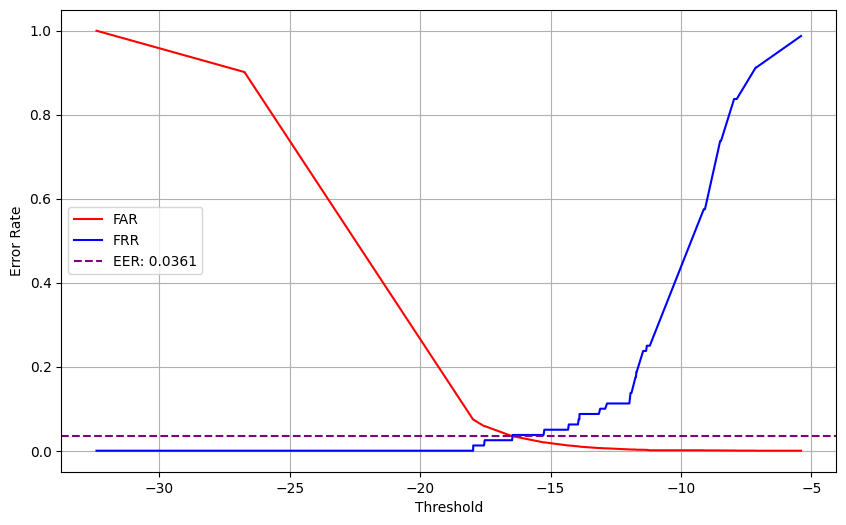

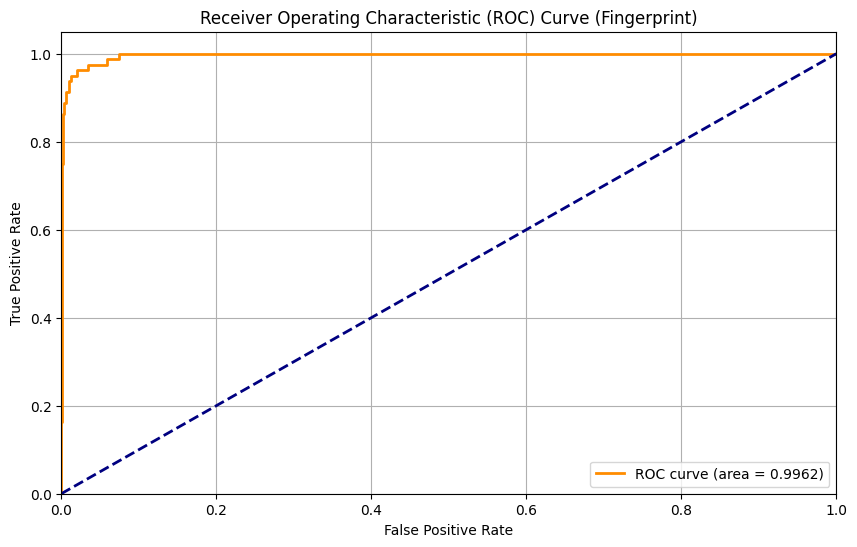

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the fingerprint test embeddings and labels
fingerprint_test_embeddings = np.load('face_test_embeddings.npy')
fingerprint_test_labels = np.load('face_test_labels.npy')

# Load trained fingerprint embeddings
trained_fingerprint_embeddings = np.load('face_embeddings.npy', allow_pickle=True).item()

distances = []
actual_labels = []

for idx, fingerprint_test_embedding in enumerate(fingerprint_test_embeddings):
    user_id = fingerprint_test_labels[idx]
    trained_user_embedding = trained_fingerprint_embeddings.get(user_id)
    
    if trained_user_embedding is not None:
        distance = np.linalg.norm(fingerprint_test_embedding - trained_user_embedding)
        distances.append(distance)
        actual_labels.append(1)
    
    for other_user_id, other_user_embedding in trained_fingerprint_embeddings.items():
        if other_user_id != user_id:
            impostor_distance = np.linalg.norm(fingerprint_test_embedding - other_user_embedding)
            distances.append(impostor_distance)
            actual_labels.append(0)

print("Unique actual_labels:", np.unique(actual_labels))

distances = np.array(distances)
actual_labels = np.array(actual_labels)

# Compute FAR, FRR, and ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, -distances)  # Negate distances for compatibility
far = fpr
frr = 1 - tpr

eer_threshold_index = np.nanargmin(np.abs(far - frr))
eer_threshold = thresholds[eer_threshold_index]
eer = (far[eer_threshold_index] + frr[eer_threshold_index]) / 2

eer_fpr = far[eer_threshold_index]
eer_frr = frr[eer_threshold_index]
print("far :", eer_fpr)
print("frr :", eer_frr)
print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

# Plot FAR, FRR, and EER
plt.figure(figsize=(10, 6))
plt.plot(thresholds, far, label='FAR', color='red')
plt.plot(thresholds, frr, label='FRR', color='blue')
plt.axhline(y=eer, color='purple', linestyle='--', label=f'EER: {eer:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

# Compute ROC curve and AUC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Fingerprint)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.
